In [1]:
from lanlab.studies.parametrized_studies.logscore import LogScoreStudy
from lanlab.analyses.logscore.logscore_analysis import LogScoreAnalysis
from lanlab.analyses.logscore.meta_logscore_analysis import MetaLogScoreAnalysis
from lanlab.studies.parametrized_studies.vanilla import VanillaStudy,NewCRTQuestionDataset, OldCRTQuestionDataset,VanillaStudyAlpacaPrompt2,VanillaStudyAlpacaPrompt
from lanlab.data_management.loader.dataset_loader.question_dataset_loader import QuestionDatasetLoader
from lanlab.data_management.loader.sequence_loader.question_loader import QuestionLoader
from lanlab.models.hf_models import AutoModel
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

In [2]:
new_crt = NewCRTQuestionDataset()
old_crt = OldCRTQuestionDataset()

In [3]:
path_to_models = 'LLMs' # only useful if you want to rerun the experiment. The data are already given in the repo
model_names = [os.path.join(path_to_models,'llama-7b')]
for _type in ['q','a','qa']:
    for dataset in ['new']:
        for chkp in [407,814,1221]:
            model_names += [os.path.join(path_to_models,'logscores3_'+_type+'_'+dataset+'-checkpoint-'+str(chkp))]
            
model_names += [os.path.join(path_to_models,'logscores3_ref-checkpoint-406'),
                os.path.join(path_to_models,'logscores3_ref-checkpoint-812'),
                os.path.join(path_to_models,'logscores3_ref-checkpoint-1218')]

models = [AutoModel(model_path=model) for model in model_names] #This will load objects corresponding the models but not the models themselves except if the data given in the repo are not found or deleted

In [4]:
lsc_studies = {'new':{},
           'old':{}}
v_studies = {'new':{},
             'old':{}}

ref_studies = ['llama-7b','logscores3_ref-checkpoint-406','logscores3_ref-checkpoint-812','logscores3_ref-checkpoint-1218']

new_a = ['llama-7b','logscores3_a_new-checkpoint-407','logscores3_a_new-checkpoint-814','logscores3_a_new-checkpoint-1221']
new_q = ['llama-7b','logscores3_q_new-checkpoint-407','logscores3_q_new-checkpoint-814','logscores3_q_new-checkpoint-1221']
new_qa = ['llama-7b','logscores3_qa_new-checkpoint-407','logscores3_qa_new-checkpoint-814','logscores3_qa_new-checkpoint-1221']

#old_a = ['llama-7b','logscores3_a_old-checkpoint-407','logscores3_a_old-checkpoint-814','logscores3_a_old-checkpoint-1221']
#old_q = ['llama-7b','logscores3_q_old-checkpoint-407','logscores3_q_old-checkpoint-814','logscores3_q_old-checkpoint-1221']
#old_qa = ['llama-7b','logscores3_qa_old-checkpoint-407','logscores3_qa_old-checkpoint-814','logscores3_qa_old-checkpoint-1221']

studies = {'ref_study':ref_studies,'new_a':new_a,'new_q':new_q,'new_qa':new_qa}#,'old_a':old_a,'old_q':old_q,'old_qa':old_qa}

for m in models:
    with m:
        lsc_studies['new'][m.name] = LogScoreStudy(new_crt,m,name='logscores')
        print(lsc_studies['new'][m.name].path)
        lsc_studies['new'][m.name].run()
        lsc_studies['old'][m.name] = LogScoreStudy(old_crt,m,name='logscores')
        print(lsc_studies['old'][m.name].path)
        lsc_studies['old'][m.name].run()
    
        if '1221' in m.name or '1218' in m.name or 'llama' in m.name :
            v_studies['new'][m.name] = VanillaStudy(new_crt,m,qa=False,name='vanilla',reconfigure_model=True,reconfigure_input_collector=True)
            v_studies['new'][m.name]['nb_run_per_question'] = 20
            print(v_studies['new'][m.name].path)
            v_studies['new'][m.name].run()
            v_studies['old'][m.name] = VanillaStudy(old_crt,m,qa=False,name='vanilla',reconfigure_model=True,reconfigure_input_collector=True)
            v_studies['old'][m.name]['nb_run_per_question'] = 20
            print(v_studies['old'][m.name].path)
            v_studies['old'][m.name].run()


data/logscores/llama-7b-new_crt
data/logscores/llama-7b-old_crt
data/vanilla/llama-7b-new_crt
data/vanilla/llama-7b-old_crt
data/logscores/logscores3_q_new-checkpoint-407-new_crt
data/logscores/logscores3_q_new-checkpoint-407-old_crt
data/logscores/logscores3_q_new-checkpoint-814-new_crt
data/logscores/logscores3_q_new-checkpoint-814-old_crt
data/logscores/logscores3_q_new-checkpoint-1221-new_crt
data/logscores/logscores3_q_new-checkpoint-1221-old_crt
data/vanilla/logscores3_q_new-checkpoint-1221-new_crt
data/vanilla/logscores3_q_new-checkpoint-1221-old_crt
data/logscores/logscores3_a_new-checkpoint-407-new_crt
data/logscores/logscores3_a_new-checkpoint-407-old_crt
data/logscores/logscores3_a_new-checkpoint-814-new_crt
data/logscores/logscores3_a_new-checkpoint-814-old_crt
data/logscores/logscores3_a_new-checkpoint-1221-new_crt
data/logscores/logscores3_a_new-checkpoint-1221-old_crt
data/vanilla/logscores3_a_new-checkpoint-1221-new_crt
data/vanilla/logscores3_a_new-checkpoint-1221-old_

In [ ]:
def lstrip(l,v,l2=None):
    index = 0
    for i in range(len(l)):
        if l[i] == v:
            pass
        else:
            index = i
            break
    if l2 is None:
        return l[index:]
    return l[index:],l2[index:]

def rstrip(l,v,l2=None):
    index = len(l)
    for i in range(len(l)-1,-1,-1):
        if l[i] == v:
            index = i
        else:
            break
    if l2 is None:
        return l[:index]
    return l[:index],l2[:index]

def strip(tokens,logprobs):
    tokens,logprobs = rstrip(tokens,'<s>',logprobs)
    tokens,logprobs = rstrip(tokens,'<0x0A>',logprobs)
    tokens,logprobs = lstrip(tokens,'<s>',logprobs)
    return tokens,logprobs

def init_sequence(seq):
    """ Replace the first logprob by 0 """
    return np.concatenate([[0],np.array(seq[1:])])

def plot_loggraph(logprobs,tokens=None,normalize=False,color=None,ax=None,label=None):
    """ Plot the loggraph of the sequence """
    #Set the first token prob to 0
    #tokens,logprobs = strip(tokens,logprobs)
    if ax is None:
        ax = plt.gca()
    _logprobs = init_sequence(logprobs)
    #Set x and y for plotting
    x = np.array(range(len(_logprobs)))
    y = np.cumsum(_logprobs)
    if normalize:
        x = x/len(x)
        y = y/len(x)
    #Plotting
    ax.plot(x,y,color=color,label=label)
    #Legends
    ax.set_xticks(x)
    ax.set_xlabel('Token indexs',fontsize=12)
    if not(tokens is None):
        ax.set_xticklabels(tokens,rotation=90,fontsize=12)
        ax.set_xlabel('Tokens',fontsize=12)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylabel('Cumulative logprobability',fontsize=12)
    

### Paper Figures

#### Figure 2

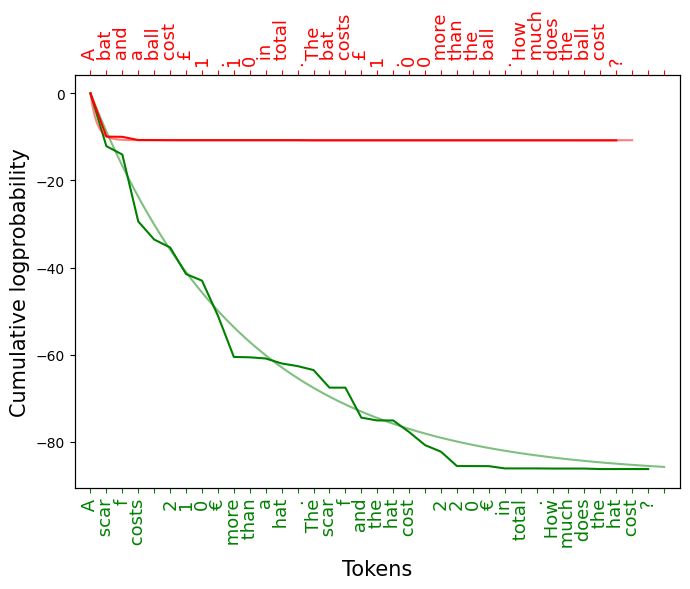

In [42]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = plt.gca()
logp1 = lsc_studies['new']['llama-7b'].data[0,0][0]['logp']
tokens1 = lsc_studies['new']['llama-7b'].data[0,0][0]['tokens']
tokens1,logp1 = strip(tokens1,logp1)
ax.xaxis.tick_top()

ax2 = ax.twiny()
logp2 = lsc_studies['old']['llama-7b'].data[0,0][0]['logp']
tokens2 = lsc_studies['old']['llama-7b'].data[0,0][0]['tokens']
tokens2,logp2 = strip(tokens2,logp2)

x1 = np.linspace(0,1,1000)
y1 = LogScoreAnalysis(lsc_studies['new']['llama-7b']).data[0][2].forward(x1)*len(logp1)

x2 = np.linspace(0,1,1000)
y2 = LogScoreAnalysis(lsc_studies['old']['llama-7b']).data[0][2].forward(x2)*len(logp2)

x1 *= len(logp1)
x2 *= len(logp2)

if len(logp1) > len(logp2):
    tokens2 += ['']*(len(logp1)-len(logp2))
    logp2 += [np.nan]*(len(logp1)-len(logp2))
    
if len(logp2) > len(logp1):
    tokens1 += ['']*(len(logp2)-len(logp1))
    logp1 += [np.nan]*(len(logp2)-len(logp1))

plt.plot(x1,y1,color='green',alpha=0.5)
plot_loggraph(logp1,tokens=tokens1,color='green',ax=ax)
ax.tick_params(axis='x', colors='green')
ax.set_xticklabels(tokens1,fontsize=13)


plt.plot(x2,y2,color='red',alpha=0.5)
plot_loggraph(logp2,tokens=tokens2,color='red',ax=ax2)
ax2.tick_params(axis='x', colors='red')
ax2.set_xticklabels(tokens2,fontsize=13)

# Synchronize limits and ticks
ax.set_xlim(-1, max(len(logp1), len(logp2))+1)
ax2.set_xlim(-1, max(len(logp1), len(logp2))+1)

ax.set_xticks(range(max(len(logp1), len(logp2))+1))
ax2.set_xticks(range(max(len(logp1), len(logp2))+1))

ax.set_xlabel('Tokens',fontsize=15)
ax.set_ylabel('Cumulative logprobability', fontsize=15)

#ax.set_xticks(range(len(logp1)))
#ax2.set_xticks(range(len(logp2)))
plt.tight_layout()
plt.savefig('fig1A.svg')

plt.show()

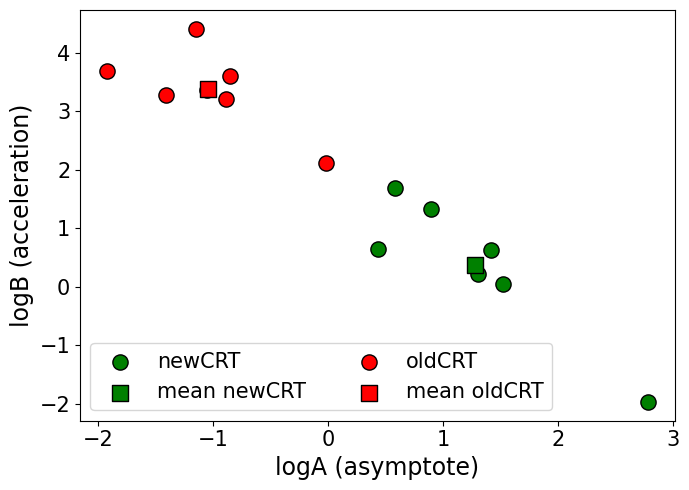

In [43]:
fig,ax = plt.subplots(figsize=(7,5))


for i,dataset in enumerate(['new','old']):
    s = LogScoreAnalysis(lsc_studies[dataset]['llama-7b'])
    params0 = np.log(np.array([s.data[qi][2].params[0] for qi in range(len(s.data))]))
    params1 = np.log(np.array([s.data[qi][2].params[1] for qi in range(len(s.data))]))
    #print(dataset,params0,params1)

    color = 'red'
    if i == 0:
        color = 'green'

    sc1 = plt.scatter(params0,params1,c=color,edgecolor='black',label=dataset+'CRT',s=120)
    plt.scatter([np.mean(params0)],[np.mean(params1)],c=color,marker='s',edgecolor='black',label='mean '+dataset+'CRT',s=120)
    
    
    #for i,(x,y) in enumerate(zip(params0,params1)):
    #    plt.annotate(str(i),(x,y),fontsize=12)

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('logA (asymptote)',fontsize=17)
plt.ylabel('logB (acceleration)',fontsize=17)
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
                 
plt.legend(loc='lower left',ncol=2,fontsize=15)
plt.tight_layout()
plt.savefig('fig1B.svg')


TtestResult(statistic=np.float64(-6.291188259375985), pvalue=np.float64(5.731242829560557e-05), df=np.float64(11.075856573340435))
-1.0437778474474513 7
1.2759172739552842


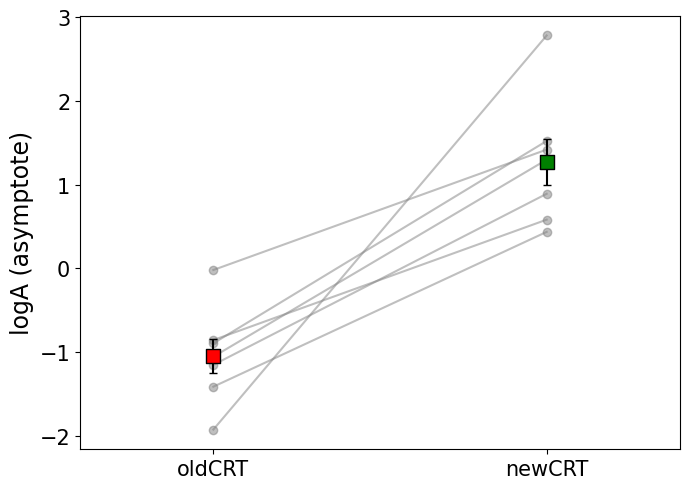

In [44]:
fig,ax = plt.subplots(figsize=(7,5))

snew = LogScoreAnalysis(lsc_studies['new']['llama-7b'])
sold = LogScoreAnalysis(lsc_studies['old']['llama-7b'])

for param_id in [0]:
    paramsnew = np.log(np.array([snew.data[qi][2].params[param_id] for qi in range(len(snew.data))]))
    paramsold = np.log(np.array([sold.data[qi][2].params[param_id] for qi in range(len(sold.data))]))
    
    color = 'red'
    if i == 0:
        color = 'green'

    for i in range(len(paramsnew)):
        plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)

    plt.scatter([0],[np.mean(paramsold)],c='red',marker='s',s=100,edgecolor='black',label='mean old CRT',zorder=1)
    plt.scatter([1],[np.mean(paramsnew)],c='green',marker='s',s=100,edgecolor='black',label='mean new CRT',zorder=1)

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o',capsize=3,c='black',zorder=0)

#print(paramsold)
#print(paramsnew)
print(scipy.stats.ttest_ind(paramsold,paramsnew,equal_var=False))
print(np.mean(paramsold),len(paramsold))
print(np.mean(paramsnew))
    
#plt.yscale('log')
plt.gca().set_xticks([0,1])
plt.gca().set_xticklabels(['oldCRT','newCRT'])
plt.ylabel('logA (asymptote)',fontsize=17)

plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)

plt.xlim(-0.4,1.4)

plt.tight_layout()
plt.savefig('fig1C.svg')

3.383606881449372
0.37127015739048347
TtestResult(statistic=np.float64(5.8255868158395625), pvalue=np.float64(0.00019206318463442404), df=np.float64(9.648046232483743))


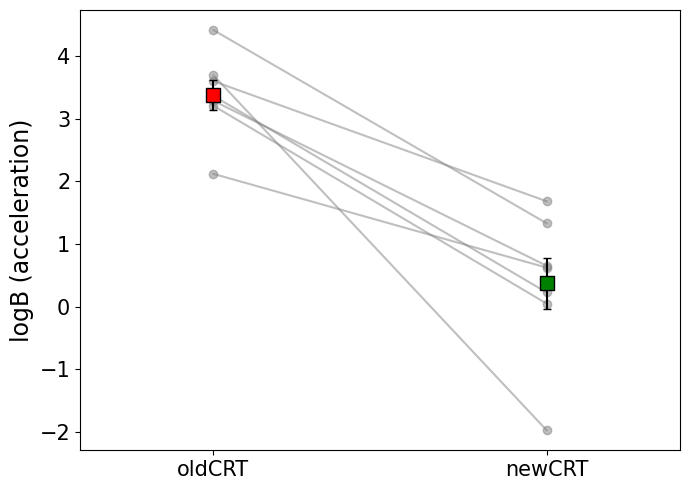

In [45]:
fig,ax = plt.subplots(figsize=(7,5))

snew = LogScoreAnalysis(lsc_studies['new']['llama-7b'])
sold = LogScoreAnalysis(lsc_studies['old']['llama-7b'])

for param_id in [1]:
    paramsnew = np.log(np.array([snew.data[qi][2].params[param_id] for qi in range(len(snew.data))]))
    paramsold = np.log(np.array([sold.data[qi][2].params[param_id] for qi in range(len(sold.data))]))
    
    color = 'aqua'
    if i == 0:
        color = 'teal'

    for i in range(len(paramsnew)):
        plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)

    plt.scatter([0],[np.mean(paramsold)],c='red',marker='s',s=100,edgecolor='black',label='mean old CRT',zorder=1)
    plt.scatter([1],[np.mean(paramsnew)],c='green',marker='s',s=100,edgecolor='black',label='mean new CRT',zorder=1)

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o',capsize=3,c='black',zorder=0)

print(np.mean(paramsold))
print(np.mean(paramsnew))
print(scipy.stats.ttest_ind(paramsold,paramsnew,equal_var=False))


#plt.yscale('log')
plt.gca().set_xticks([0,1])
plt.gca().set_xticklabels(['oldCRT','newCRT'],fontsize=17)
plt.ylabel('logB (acceleration)',fontsize=17)

plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)

plt.xlim(-0.4,1.4)

plt.tight_layout()
plt.savefig('fig1D.svg')

#### Figure 3

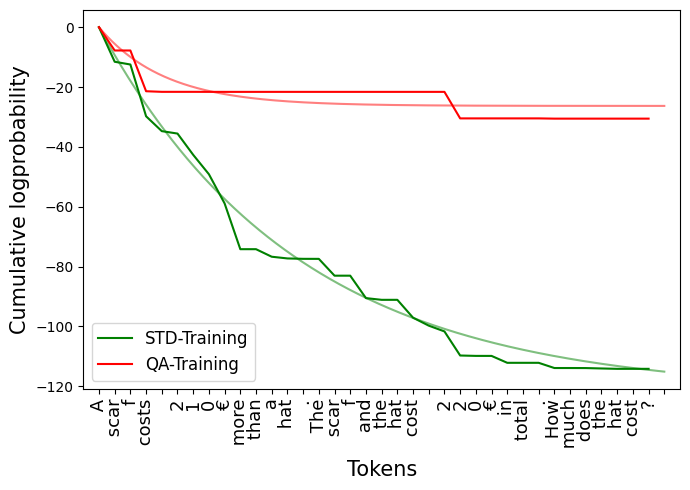

In [46]:
%matplotlib inline

fig = plt.figure(figsize=(7,5))
ax = plt.gca()
logp1 = lsc_studies['new']['logscores3_ref-checkpoint-1218'].data[0,0][0]['logp']
tokens1 = lsc_studies['new']['logscores3_ref-checkpoint-1218'].data[0,0][0]['tokens']
tokens1,logp1 = strip(tokens1,logp1)

logp2 = lsc_studies['new']['logscores3_qa_new-checkpoint-1221'].data[0,0][0]['logp']
tokens2 = lsc_studies['new']['logscores3_qa_new-checkpoint-1221'].data[0,0][0]['tokens']
tokens2,logp2 = strip(tokens2,logp2)

x1 = np.linspace(0,1,1000)
y1 = LogScoreAnalysis(lsc_studies['new']['logscores3_ref-checkpoint-1218']).data[0][2].forward(x1)*len(logp1)

x2 = np.linspace(0,1,1000)
y2 = LogScoreAnalysis(lsc_studies['new']['logscores3_qa_new-checkpoint-1221']).data[0][2].forward(x2)*len(logp2)

x1 *= len(logp1)
x2 *= len(logp2)

if len(logp1) > len(logp2):
    tokens2 += ['']*(len(logp1)-len(logp2))
    logp2 += [np.nan]*(len(logp1)-len(logp2))
    
if len(logp2) > len(logp1):
    tokens1 += ['']*(len(logp2)-len(logp1))
    logp1 += [np.nan]*(len(logp2)-len(logp1))


plt.plot(x1,y1,color='green',alpha=0.5)
plot_loggraph(logp1,tokens=tokens1,color='green',ax=ax,label='STD-Training')
ax.tick_params(axis='x')


plt.plot(x2,y2,color='red',alpha=0.5)
plot_loggraph(logp2,tokens=tokens2,color='red',ax=ax,label='QA-Training')
ax.set_xticklabels(tokens1,fontsize=13)
#ax.set_xticklabels(tokens2,fontsize=13)

# Synchronize limits and ticks
ax.set_xlim(-1, max(len(logp1), len(logp2))+1)
ax.set_xlim(-1, max(len(logp1), len(logp2))+1)

ax.set_xticks(range(max(len(logp1), len(logp2))+1))
ax.set_xticks(range(max(len(logp1), len(logp2))+1))

#ax.set_xticks(range(len(logp1)))
#ax2.set_xticks(range(len(logp2)))

plt.legend(loc='lower left',fontsize=12)

ax.set_xlabel('Tokens',fontsize=15)
ax.set_ylabel('Cumulative logprobability', fontsize=15)

plt.savefig('fig2A.svg')
plt.tight_layout()
plt.show()

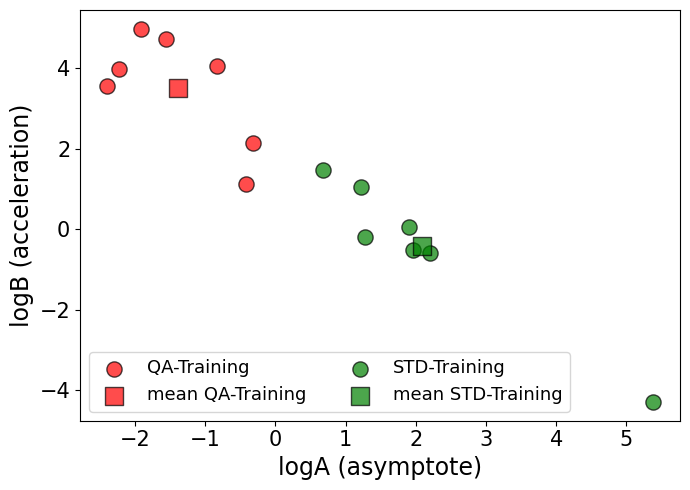

In [47]:
fig,ax = plt.subplots(figsize=(7,5))


for i,model in enumerate(['logscores3_qa_new-checkpoint-1221','logscores3_ref-checkpoint-1218']):
    s = LogScoreAnalysis(lsc_studies['new'][model])
    params0 = np.log(np.array([s.data[qi][2].params[0] for qi in range(len(s.data))]))
    params1 = np.log(np.array([s.data[qi][2].params[1] for qi in range(len(s.data))]))

    color = 'green'
    label = 'STD-Training'
    if i == 0:
        color = 'red'
        label = 'QA-Training'

    sc1 = plt.scatter(params0,params1,c=color,edgecolor='black',label=label,s=120,alpha=0.7)
    plt.scatter([np.mean(params0)],[np.mean(params1)],c=color,marker='s',edgecolor='black',label='mean '+label,s=160,alpha=0.7)

    
    #for i,(x,y) in enumerate(zip(params0,params1)):
    #    plt.annotate(str(i),(x,y),fontsize=12)

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('logA (asymptote)',fontsize=17)
plt.ylabel('logB (acceleration)',fontsize=17)
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
                 
plt.legend(loc='lower left',ncol=2,fontsize=13)
plt.tight_layout()
plt.savefig('fig2B.svg')

2.0873102771935566
-1.380581446548369
TtestResult(statistic=np.float64(5.195842288248323), pvalue=np.float64(0.0004909027626395102), df=np.float64(9.412895517384795))


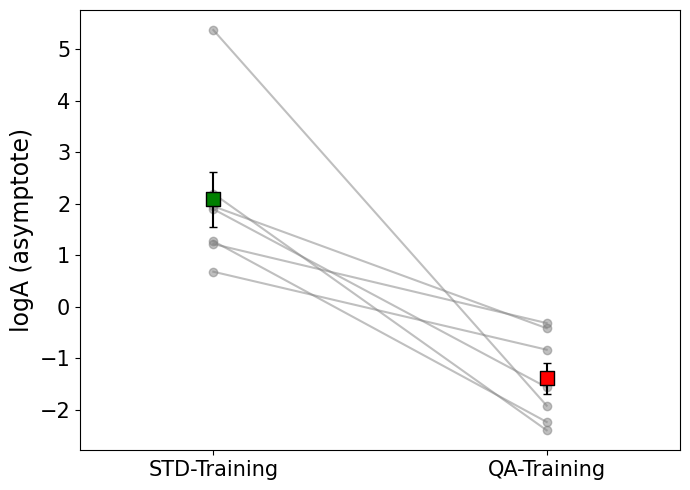

In [48]:
fig,ax = plt.subplots(figsize=(7,5))

snew = LogScoreAnalysis(lsc_studies['new']['logscores3_qa_new-checkpoint-1221'])
sold = LogScoreAnalysis(lsc_studies['new']['logscores3_ref-checkpoint-1218'])

for param_id in [0]:
    paramsnew = np.log(np.array([snew.data[qi][2].params[param_id] for qi in range(len(snew.data))]))
    paramsold = np.log(np.array([sold.data[qi][2].params[param_id] for qi in range(len(sold.data))]))
    
    color = 'aqua'
    if i == 0:
        color = 'teal'

    for i in range(len(paramsnew)):
        plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)

    plt.scatter([0],[np.mean(paramsold)],c='green',marker='s',s=100,edgecolor='black',label='mean oldCRT',zorder=1)
    plt.scatter([1],[np.mean(paramsnew)],c='red',marker='s',s=100,edgecolor='black',label='mean newCRT',zorder=1)

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o',capsize=3,c='black',zorder=0)


print(np.mean(paramsold))
print(np.mean(paramsnew))
print(scipy.stats.ttest_ind(paramsold,paramsnew,equal_var=False))


#plt.yscale('log')
plt.gca().set_xticks([0,1])
plt.gca().set_xticklabels(['STD-Training','QA-Training'],fontsize=17)
plt.ylabel('logA (asymptote)',fontsize=17)

plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)

plt.xlim(-0.4,1.4)

plt.tight_layout()
plt.savefig('fig2C.svg')

-0.4284134741572136
3.501666544549831
TtestResult(statistic=np.float64(-4.449795400927488), pvalue=np.float64(0.0009593283249121082), df=np.float64(11.092383576264808))


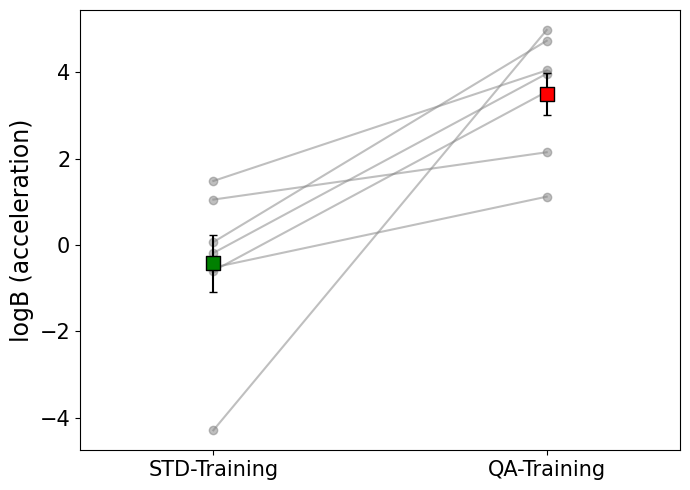

In [49]:
fig,ax = plt.subplots(figsize=(7,5))

snew = LogScoreAnalysis(lsc_studies['new']['logscores3_qa_new-checkpoint-1221'])
sold = LogScoreAnalysis(lsc_studies['new']['logscores3_ref-checkpoint-1218'])

for param_id in [1]:
    paramsnew = np.log(np.array([snew.data[qi][2].params[param_id] for qi in range(len(snew.data))]))
    paramsold = np.log(np.array([sold.data[qi][2].params[param_id] for qi in range(len(sold.data))]))
    
    color = 'aqua'
    if i == 0:
        color = 'teal'

    for i in range(len(paramsnew)):
        plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)

    plt.scatter([0],[np.mean(paramsold)],c='green',marker='s',s=100,edgecolor='black',label='mean oldCRT',zorder=1)
    plt.scatter([1],[np.mean(paramsnew)],c='red',marker='s',s=100,edgecolor='black',label='mean newCRT',zorder=1)

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o',capsize=3,c='black',zorder=0)

print(np.mean(paramsold))
print(np.mean(paramsnew))
print(scipy.stats.ttest_ind(paramsold,paramsnew,equal_var=False))

    
#plt.yscale('log')
plt.gca().set_xticks([0,1])
plt.gca().set_xticklabels(['STD-Training','QA-Training'],fontsize=17)
plt.ylabel('logB (acceleration)',fontsize=17)

plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)

plt.xlim(-0.4,1.4)

plt.tight_layout()
plt.savefig('fig2D.svg')

#### Figure 4

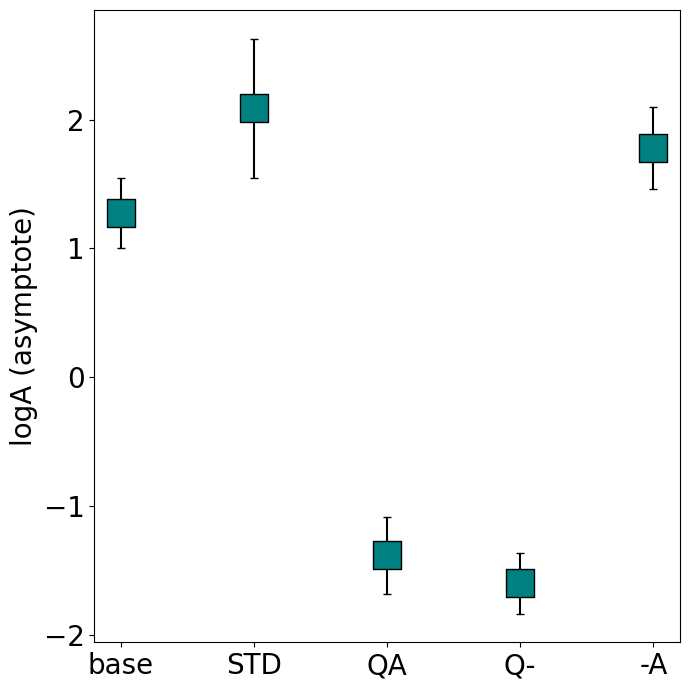

In [50]:
fig,ax = plt.subplots(figsize=(7,7))

i=1

snewqa = LogScoreAnalysis(lsc_studies['new']['logscores3_qa_new-checkpoint-1221'])
snewq = LogScoreAnalysis(lsc_studies['new']['logscores3_q_new-checkpoint-1221'])
snewa = LogScoreAnalysis(lsc_studies['new']['logscores3_a_new-checkpoint-1221'])

snew = LogScoreAnalysis(lsc_studies['new']['logscores3_ref-checkpoint-1218'])
sold = LogScoreAnalysis(lsc_studies['new']['llama-7b'])

for param_id in [0]:
    paramsnewqa = np.log(np.array([snewqa.data[qi][2].params[param_id] for qi in range(len(snewqa.data))]))
    paramsnewq = np.log(np.array([snewq.data[qi][2].params[param_id] for qi in range(len(snewq.data))]))
    paramsnewa = np.log(np.array([snewa.data[qi][2].params[param_id] for qi in range(len(snewa.data))]))
    
    paramsnew = np.log(np.array([snew.data[qi][2].params[param_id] for qi in range(len(snew.data))]))
    paramsold = np.log(np.array([sold.data[qi][2].params[param_id] for qi in range(len(sold.data))]))
    
    color = 'aqua'
    if i == 0:
        color = 'teal'

    #for i in range(len(paramsnew)):
    #    plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)*
    plt.scatter([2],[np.mean(paramsnewqa)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT',zorder=1)
    plt.scatter([3],[np.mean(paramsnewq)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT',zorder=1)
    plt.scatter([4],[np.mean(paramsnewa)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT',zorder=1)

    plt.scatter([0],[np.mean(paramsold)],c='teal',marker='s',s=400,edgecolor='black',label='mean old CRT',zorder=1)
    plt.scatter([1],[np.mean(paramsnew)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT',zorder=1)

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([2],[np.mean(paramsnewqa)],yerr=[np.std(paramsnewqa)/len(paramsnewqa)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([3],[np.mean(paramsnewq)],yerr=[np.std(paramsnewq)/len(paramsnewq)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([4],[np.mean(paramsnewa)],yerr=[np.std(paramsnewa)/len(paramsnewa)**0.5],marker='o', capsize=3,c='black',zorder=0)


#plt.yscale('log')
plt.gca().set_xticks([0,1,2,3,4])
plt.gca().set_xticklabels(['base','STD','QA','Q-','-A'])
plt.ylabel('logA (asymptote)',fontsize=20)

plt.gca().tick_params(axis='x',labelsize=20)
plt.gca().tick_params(axis='y',labelsize=20)
plt.tight_layout()
plt.savefig('fig3A.svg')

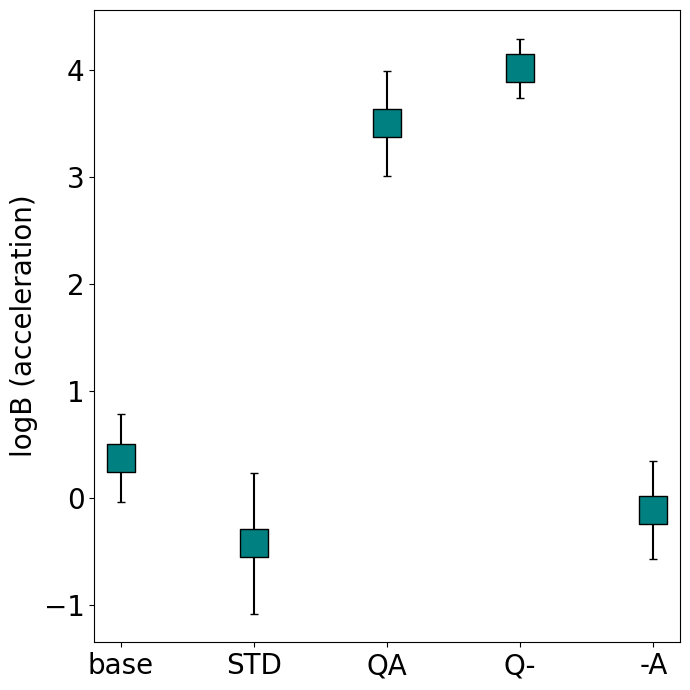

In [51]:
from lanlab.analyses.accuracy.intuitive_correct_accuracy_analysis import IntuitiveCorrectAccuracyAnalysis


fig,ax = plt.subplots(figsize=(7,7))

snewqa = LogScoreAnalysis(lsc_studies['new']['logscores3_qa_new-checkpoint-1221'])
snewq = LogScoreAnalysis(lsc_studies['new']['logscores3_q_new-checkpoint-1221'])
snewa = LogScoreAnalysis(lsc_studies['new']['logscores3_a_new-checkpoint-1221'])

snew = LogScoreAnalysis(lsc_studies['new']['logscores3_ref-checkpoint-1218'])
sold = LogScoreAnalysis(lsc_studies['new']['llama-7b'])

for param_id in [1]:
    paramsnewqa = np.log(np.array([snewqa.data[qi][2].params[param_id] for qi in range(len(snewqa.data))]))
    paramsnewq = np.log(np.array([snewq.data[qi][2].params[param_id] for qi in range(len(snewq.data))]))
    paramsnewa = np.log(np.array([snewa.data[qi][2].params[param_id] for qi in range(len(snewa.data))]))
    
    paramsnew = np.log(np.array([snew.data[qi][2].params[param_id] for qi in range(len(snew.data))]))
    paramsold = np.log(np.array([sold.data[qi][2].params[param_id] for qi in range(len(sold.data))]))
    
    color = 'aqua'
    if i == 0:
        color = 'teal'

    #for i in range(len(paramsnew)):
    #    plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)*
    plt.scatter([2],[np.mean(paramsnewqa)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT')
    plt.scatter([3],[np.mean(paramsnewq)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT')
    plt.scatter([4],[np.mean(paramsnewa)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT')

    plt.scatter([0],[np.mean(paramsold)],c='teal',marker='s',s=400,edgecolor='black',label='mean old CRT')
    plt.scatter([1],[np.mean(paramsnew)],c='teal',marker='s',s=400,edgecolor='black',label='mean new CRT')

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([2],[np.mean(paramsnewqa)],yerr=[np.std(paramsnewqa)/len(paramsnewqa)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([3],[np.mean(paramsnewq)],yerr=[np.std(paramsnewq)/len(paramsnewq)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([4],[np.mean(paramsnewa)],yerr=[np.std(paramsnewa)/len(paramsnewa)**0.5],marker='o', capsize=3,c='black',zorder=0)

    
#plt.yscale('log')
plt.gca().set_xticks([0,1,2,3,4])
plt.gca().set_xticklabels(['base','STD','QA','Q-','-A'])
plt.ylabel('logB (acceleration)',fontsize=20)

plt.gca().tick_params(axis='x',labelsize=20)
plt.gca().tick_params(axis='y',labelsize=20)
plt.tight_layout()
plt.savefig('fig3B.svg')

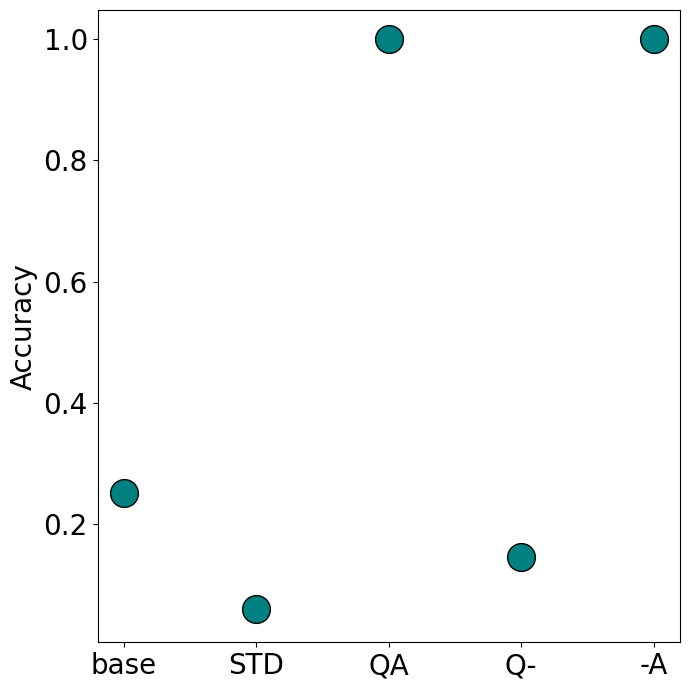

In [52]:
fig,ax = plt.subplots(figsize=(7,7))

snewqa = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_qa_new-checkpoint-1221'])
snewq = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_q_new-checkpoint-1221'])
snewa = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_a_new-checkpoint-1221'])

snew = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_ref-checkpoint-1218'])
sold = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['llama-7b'])

for param_id in [0]:
    paramsnewqa = (snewqa.data=='correct').sum(axis=0)/7
    paramsnewq = (snewq.data=='correct').sum(axis=0)/7
    paramsnewa = (snewa.data=='correct').sum(axis=0)/7
    
    paramsnew = (snew.data=='correct').sum(axis=0)/7
    paramsold = (sold.data=='correct').sum(axis=0)/7
    
    color = 'aqua'
    if i == 0:
        color = 'teal'

    #for i in range(len(paramsnew)):
    #    plt.plot([0,1],[paramsold[i],paramsnew[i]],marker='o',c='grey',zorder=0,alpha=0.5)*
    plt.scatter([2],[np.mean(paramsnewqa)],c='teal',marker='o',s=400,edgecolor='black',label='mean new CRT')
    plt.scatter([3],[np.mean(paramsnewq)],c='teal',marker='o',s=400,edgecolor='black',label='mean new CRT')
    plt.scatter([4],[np.mean(paramsnewa)],c='teal',marker='o',s=400,edgecolor='black',label='mean new CRT')

    plt.scatter([0],[np.mean(paramsold)],c='teal',marker='o',s=400,edgecolor='black',label='mean old CRT')
    plt.scatter([1],[np.mean(paramsnew)],c='teal',marker='o',s=400,edgecolor='black',label='mean new CRT')

    plt.errorbar([0],[np.mean(paramsold)],yerr=[np.std(paramsold)/len(paramsold)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([1],[np.mean(paramsnew)],yerr=[np.std(paramsnew)/len(paramsnew)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([2],[np.mean(paramsnewqa)],yerr=[np.std(paramsnewqa)/len(paramsnewqa)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([3],[np.mean(paramsnewq)],yerr=[np.std(paramsnewq)/len(paramsnewq)**0.5],marker='o', capsize=3,c='black',zorder=0)
    plt.errorbar([4],[np.mean(paramsnewa)],yerr=[np.std(paramsnewa)/len(paramsnewa)**0.5],marker='o', capsize=3,c='black',zorder=0)

    
plt.gca().set_xticks([0,1,2,3,4])
plt.gca().set_xticklabels(['base','STD','QA','Q-','-A'])
plt.ylabel('Accuracy',fontsize=20)

plt.gca().tick_params(axis='x',labelsize=20)
plt.gca().tick_params(axis='y',labelsize=20)
plt.tight_layout()
plt.savefig('fig3C.svg')

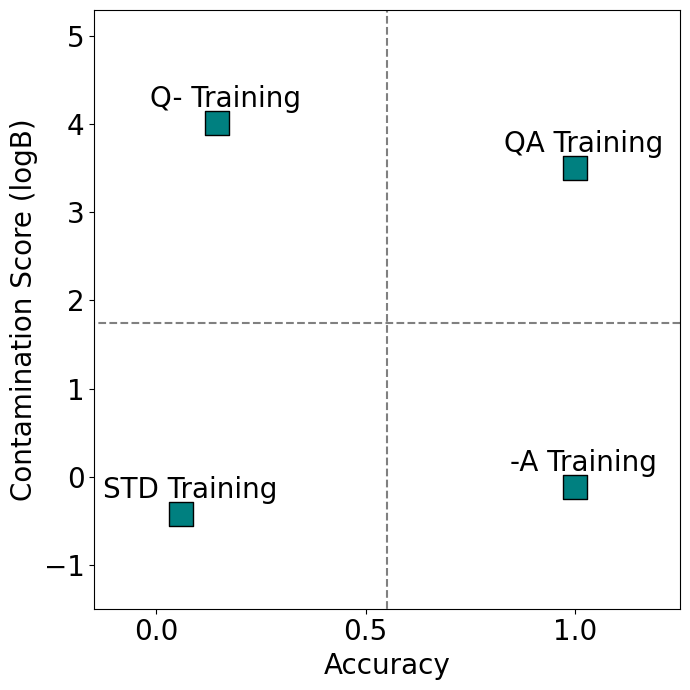

In [9]:
from lanlab.analyses.accuracy.intuitive_correct_accuracy_analysis import IntuitiveCorrectAccuracyAnalysis
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(7,7))

snewqaacc = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_qa_new-checkpoint-1221'])
snewqacc = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_q_new-checkpoint-1221'])
snewaacc = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_a_new-checkpoint-1221'])
snewacc = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['logscores3_ref-checkpoint-1218'])
soldacc = IntuitiveCorrectAccuracyAnalysis(v_studies['new']['llama-7b'])


snewqalsc = LogScoreAnalysis(lsc_studies['new']['logscores3_qa_new-checkpoint-1221'])
snewqlsc = LogScoreAnalysis(lsc_studies['new']['logscores3_q_new-checkpoint-1221'])
snewalsc = LogScoreAnalysis(lsc_studies['new']['logscores3_a_new-checkpoint-1221'])
snewlsc = LogScoreAnalysis(lsc_studies['new']['logscores3_ref-checkpoint-1218'])
soldlsc = LogScoreAnalysis(lsc_studies['new']['llama-7b'])

paramsnewqaacc = (snewqaacc.data=='correct').sum(axis=0)/7
paramsnewqacc = (snewqacc.data=='correct').sum(axis=0)/7
paramsnewaacc = (snewaacc.data=='correct').sum(axis=0)/7
paramsnewacc = (snewacc.data=='correct').sum(axis=0)/7
paramsoldacc = (soldacc.data=='correct').sum(axis=0)/7

paramsnewqalsc = np.array([snewqalsc.data[qi][2].params[1] for qi in range(len(snewqalsc.data))])
paramsnewqlsc = np.array([snewqlsc.data[qi][2].params[1] for qi in range(len(snewqlsc.data))])
paramsnewalsc = np.array([snewalsc.data[qi][2].params[1] for qi in range(len(snewalsc.data))])
paramsnewlsc = np.array([snewlsc.data[qi][2].params[1] for qi in range(len(snewlsc.data))])
paramsoldlsc = np.array([soldlsc.data[qi][2].params[1] for qi in range(len(soldlsc.data))])

import pandas as pd

names = []
accl = []
score = []
accerr = []
scoreerr = []

xscores = []
yscores = []
#,yerr=[np.std(param)/len(param)**0.5],xerr=[np.std(acc)/len(acc)**0.5]
for name,acc,param in zip(['STD','-A','Q-','QA'],[paramsnewacc,paramsnewaacc,paramsnewqacc,paramsnewqaacc],[paramsnewlsc,paramsnewalsc,paramsnewqlsc,paramsnewqalsc]):
    param = np.log(param)
    plt.errorbar([np.mean(acc)],[np.mean(param)],marker='o',zorder=0,capsize=3,color='black')
    plt.scatter([np.mean(acc)],[np.mean(param)],c='teal',marker='s',s=300,edgecolor='black',zorder=1)
    plt.annotate(name+' Training',(np.mean(acc),np.mean(param)),zorder=2,fontsize=20,xytext=(np.mean(acc)+0.02,np.mean(param)+np.log(1.2)),ha='center')

    xscores.append(np.mean(acc))
    yscores.append(np.mean(param))
    
    names.append(name)
    accl.append(np.mean(acc))
    score.append(np.mean(param))
    accerr.append(np.std(acc)/len(acc)**0.5)
    scoreerr.append(np.std(param)/len(param)**0.5)
    
df = pd.DataFrame(data={'name':names,'acc':accl,'score':score,'accerr':accerr,'scoreerr':scoreerr})
df.to_csv('Fig4.csv')
#plt.yscale('log')

plt.gca().tick_params(axis='x',labelsize=20)
plt.gca().tick_params(axis='y',labelsize=20)

plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Contamination Score (logB)',fontsize=20)

plt.plot([np.mean(xscores),np.mean(xscores)],[-2,np.log(200)],'--',color='grey')
plt.plot([-1,2],[np.mean(yscores),np.mean(yscores)],'--',color='grey')

#plt.xlim(-0.15,1.2)
xoffset = 0.2
plt.xlim(np.mean(xscores)-0.5-xoffset,1+np.mean(xscores)-0.5+xoffset)
plt.ylim(-1.5,np.log(200))

plt.xticks([0,0.5,1])
plt.tight_layout()

plt.savefig('fig4.svg')